# TIME SERIES FORECASTING

In [225]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [226]:
df=pd.read_csv("shampoo.csv")

In [227]:
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   36 non-null     object 
 1   Sales   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 704.0+ bytes


In [229]:
df['Year1']=df['Month'].apply(lambda x:str(x)[0:1]) #Create a new column with the year ( 1, 2 or 3)
#Convert the year number to a real year
df.loc[df['Year1']=='1', 'Year'] = '2018' 
df.loc[df['Year1']=='2', 'Year'] = '2019'
df.loc[df['Year1']=='3', 'Year'] = '2020'
#Modify Month column to have just the month and not the 1,2 or 3 anymore
df['Month']=df['Month'].apply(lambda x:str(x)[2:4])
#Create a Date column with year. month and then convert it to datetime
df['Date']=pd.to_datetime(df['Year'] + '-' + df['Month'])
df=df.drop(['Year1','Year','Month'], axis=1)

In [230]:
df.head(13)

,Sales,Date
0,266.0,2018-01-01
1,145.9,2018-02-01
2,183.1,2018-03-01
3,119.3,2018-04-01
4,180.3,2018-05-01
5,168.5,2018-06-01
6,231.8,2018-07-01
7,224.5,2018-08-01
8,192.8,2018-09-01
9,122.9,2018-10-01


In [231]:
df = df.set_index('Date')

In [232]:
#df.index = pd.DatetimeIndex(df.index).to_period('M')

In [233]:
df.head()

,Sales
Date,
2018-01-01,266.0
2018-02-01,145.9
2018-03-01,183.1
2018-04-01,119.3
2018-05-01,180.3


 Now the dataframe is ready to be analyzed

# Stationarity analysis

<AxesSubplot:xlabel='Date'>

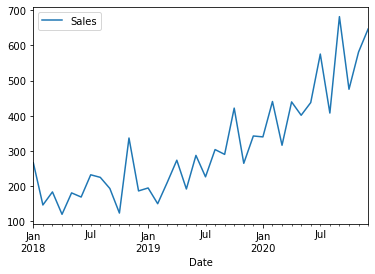

In [234]:
df.plot()

The time series does not look stationary 

## Augmented Dickey Fuller test

Augmented Dickey Fuller (ADF) test to check if the price series is stationary.
The null hypothesis of the ADF is that the time series is non stationary. So, if the p-value of the test is less than a signficance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

In [235]:
from statsmodels.tsa.stattools import adfuller

result=adfuller(df.Sales.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:3.0601420836411806
p-value:1.0


The p-value is higher than 0.05, so the Null Hypothesis ( NON-stationarity) cannot be rejected

# ARIMA model

In [236]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

First, we will design an ARIMA model of the timeseries and evaluate its performance using the available diagnostic tools.

### Check the difference order

Without difference:

In [237]:
result=adfuller(df.Sales.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:3.0601420836411806
p-value:1.0


With 1-order difference:

In [238]:
result=adfuller(df.Sales.diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-7.249074055553854
p-value:1.7998574141687034e-10


The p-value is far smaller than 0.05, so now the series is stationary. 

With 2-order difference:

In [239]:
result=adfuller(df.Sales.diff().diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-3.7150529231170273
p-value:0.0039063349396599245


The p-value increased with 2-order difference. We will keep a 1-order difference.

In order to choose the model order (find the p and q values) for the ARIMA model, we will analyze the ACF and PACF

## ACF AND PACF

The following table will help to identify the model:

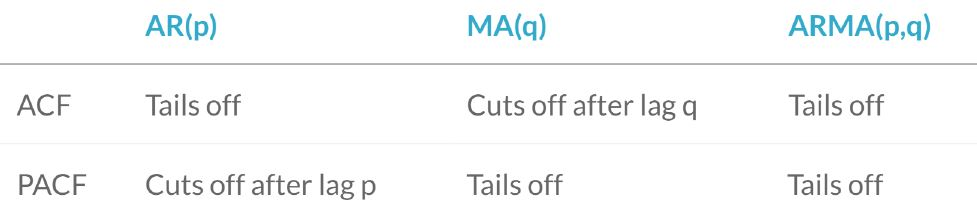

In [240]:
from IPython.display import Image
Image(filename='pacfacf.jpg',width=800, height=400)

In [241]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

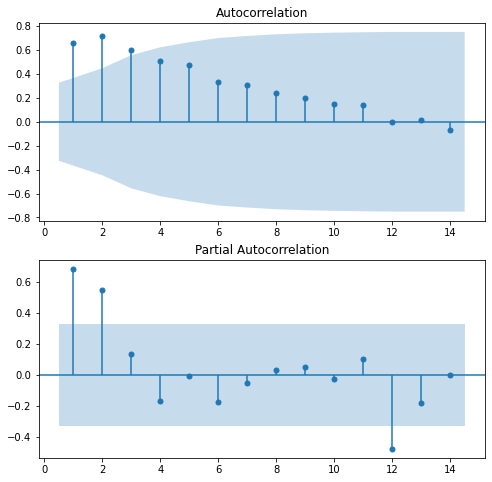

In [242]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(df,lags=14, zero=False, ax=ax1)
plot_pacf(df,lags=14, zero=False, ax=ax2)
plt.show()

Indeed the series looks non stationary

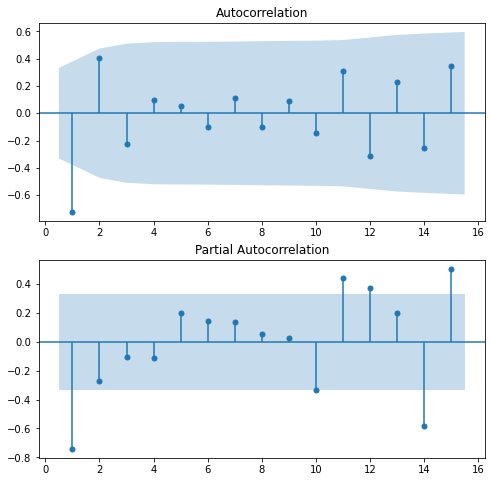

In [243]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(df.diff().dropna(),lags=15, zero=False, ax=ax1)
plot_pacf(df.diff().dropna(),lags=15, zero=False, ax=ax2)
plt.show()

The series looks more stationary after a 1-order difference

## AIC and BIC to evaluate the model

In [244]:
#The hyperparameter tuning rise some warnings, since they are not helpful they will be ignored
import warnings
warnings.filterwarnings("ignore")

In [245]:
order_aic_bic =[]
# Loop over AR order
for p in range( 3 ):
    # Loop over MA order
    for q in range(3):
        # Fit model
        model = SARIMAX(df, order=(p, 1 ,q))
        results = model.fit()
        # Add order and scores to list
        order_aic_bic.append((p, q, results.aic, results.bic))
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=[ 'p' , 'q' , 'aic' , 'bic' ])    

In [246]:
# Sort by AIC-> better indicator for prediction
print(order_df.sort_values('aic'))

   p  q         aic         bic
2  0  2  399.460919  404.126963
5  1  2  401.262923  407.484315
6  2  0  406.376157  411.042201
3  1  0  406.574925  409.685621
4  1  1  406.782345  411.448389
7  2  1  407.112366  413.333758
8  2  2  408.413784  416.190524
1  0  1  413.125234  416.235930
0  0  0  429.228747  430.784095


In [247]:
# Sort by BIC-> better indicator for data exploration
print(order_df.sort_values('bic'))

   p  q         aic         bic
2  0  2  399.460919  404.126963
5  1  2  401.262923  407.484315
3  1  0  406.574925  409.685621
6  2  0  406.376157  411.042201
4  1  1  406.782345  411.448389
7  2  1  407.112366  413.333758
8  2  2  408.413784  416.190524
1  0  1  413.125234  416.235930
0  0  0  429.228747  430.784095


It looks like (p,q)=(0,2) are the best values

### Now we can fit an ARIMA MODEL

# ARIMA MODEL FIT

In [248]:
model=SARIMAX(df,order=(0,1,2))

In [249]:
results=model.fit()

In [250]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -196.730
Date:                Thu, 01 Jul 2021   AIC                            399.461
Time:                        14:23:15   BIC                            404.127
Sample:                    01-01-2018   HQIC                           401.072
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3002      2.420     -0.537      0.591      -6.042       3.442
ma.L2          0.9940      3.683      0.270      0.787      -6.225       8.213
sigma2      3748.6601   1.37e+04      0.274      0.784   -2.31e+04    3.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.76   Prob(JB):                         0.99
Heteroskedasticity (H):               0.99   Skew:                            -0.04
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [275]:
#Residual analysis
residuals=results.resid
mae = np.mean(np.abs(residuals))
mae

58.91878107401375

### Diagnostics

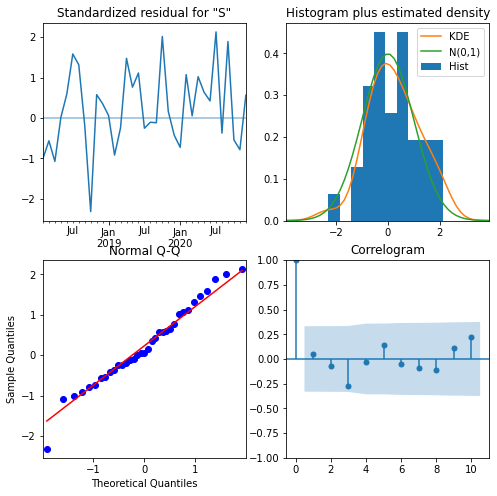

In [276]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(8,8))
plt.show()

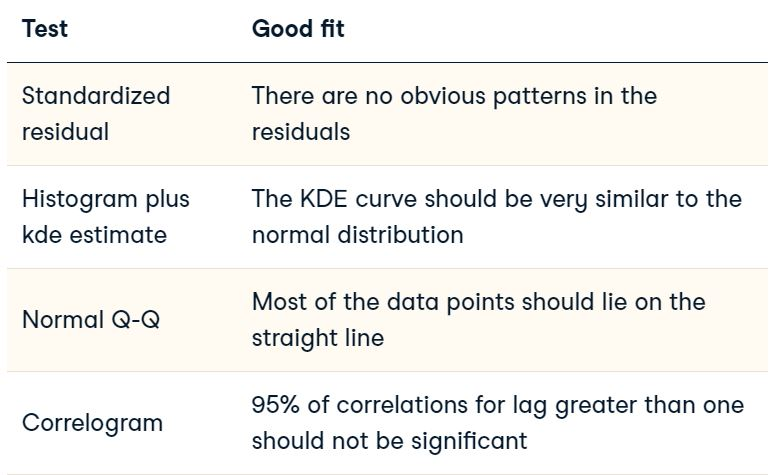

In [277]:
from IPython.display import Image
Image(filename='diagnostics.jpg',width=400, height=400)

The diagnostics do not look bad. We can still improve in terms of Normal Q-Q and Histogram

## ARIMA PREDICTION

In [261]:
# Make ARIMA forecast of next 10 values
prediction = results.get_prediction(start=-10)
mean_prediction=prediction.predicted_mean

# Print forecast
print(mean_prediction)

2020-03-01    312.526204
2020-04-01    374.716180
2020-05-01    361.155905
2020-06-01    410.743143
2020-07-01    441.293306
2020-08-01    431.124505
2020-09-01    563.150002
2020-10-01    509.359299
2020-11-01    630.476809
2020-12-01    611.462953
Freq: MS, Name: predicted_mean, dtype: float64


## Confidence Interval

In [262]:
confi_int=prediction.conf_int()
lower_limits=confi_int.iloc[:,0]
upper_limits=confi_int.iloc[:,1]
confi_int

,lower Sales,upper Sales
2020-03-01,188.411249,436.641158
2020-04-01,250.692358,498.740003
2020-05-01,237.419956,484.891853
2020-06-01,287.164497,534.321789
2020-07-01,317.715208,564.871405
2020-08-01,307.685178,554.563831
2020-09-01,439.931442,686.368561
2020-10-01,386.201227,632.517371
2020-11-01,507.336508,753.617109
2020-12-01,488.481542,734.444363


### Dates indeces for all data and forecasted data

In [263]:
pred_dates=np.asarray(mean_prediction.index)
dates=np.asarray(df.index)

## Real data and predicted data PLOT

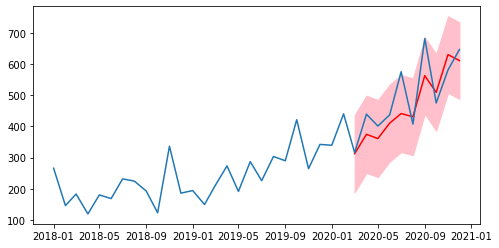

In [264]:
plt.figure(figsize=(8,4))
plt.plot(pred_dates,mean_prediction.values,color='red',label='forecast')
plt.fill_between(pred_dates, lower_limits, upper_limits, color='pink')
plt.plot(dates,df.values)
plt.show()

# ARIMA FORECASTING

In [278]:
# Make ARIMA forecast of next 10 values
mean_forecast = results.get_forecast(steps=2).predicted_mean
mean_forecast

2021-01-01    555.490992
2021-02-01    589.030519
Freq: MS, Name: predicted_mean, dtype: float64

In [270]:
forec_dates =np.asarray(mean_forecast.index)

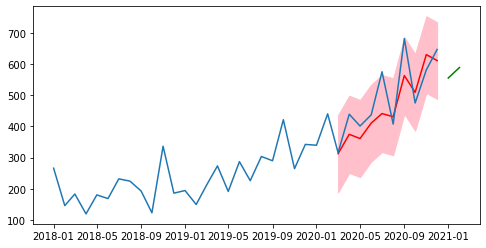

In [274]:
plt.figure(figsize=(8,4))
plt.plot(pred_dates,mean_prediction.values,color='red',label='forecast')
plt.plot(forec_dates,mean_forecast.values,color='green',label='predicted')
plt.fill_between(pred_dates, lower_limits, upper_limits, color='pink')
plt.plot(dates,df.values)
plt.show()